### Setting up the environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
from sklearn.svm import SVC
import os

### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/ProjectML/data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


selected_classes = train_dataset.classes

class CustomValDataset(Dataset):
    def __init__(self, img_dir, annotations_df, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.data = annotations_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

annotations_path = '/content/drive/MyDrive/Colab Notebooks/ProjectML/data/val/val_annotations.txt'
annotations_df = pd.read_csv(annotations_path, sep='\t', header=None)
annotations_df.columns = ['image', 'class', 'x1', 'y1', 'x2', 'y2']
filtered_val_df = annotations_df[annotations_df['class'].isin(selected_classes)][['image', 'class']]

val_dataset = CustomValDataset('/content/drive/MyDrive/Colab Notebooks/ProjectML/data/val/images', filtered_val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# -- NOTE FOR QUICK TESTING --
#
# filtered_val_df = filtered_val_df.groupby('class').head(1)  # 1 image per class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.to(device)
resnet.eval()

def extract_features(dataloader, is_val=False):
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = resnet(imgs).squeeze()
            features.append(feats.cpu().numpy())

            if is_val:
                labels.extend(lbls)
            else:
                labels.extend([train_dataset.classes[i] for i in lbls])

    return np.vstack(features), np.array(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(val_loader, is_val=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train with different kernels (SVM)

Best C for kernel=linear: 0.1
Validation Accuracy for kernel=linear: 88.800%
              precision    recall  f1-score   support

   n01443537       0.92      0.96      0.94        50
   n02410509       0.89      0.98      0.93        50
   n03977966       1.00      1.00      1.00        50
   n07715103       0.84      0.76      0.80        50
   n07747607       0.80      0.74      0.77        50
   n07768694       0.82      0.84      0.83        50
   n07873807       0.94      0.96      0.95        50
   n07920052       0.94      0.94      0.94        50
   n09256479       0.90      0.92      0.91        50
   n12267677       0.80      0.78      0.79        50

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



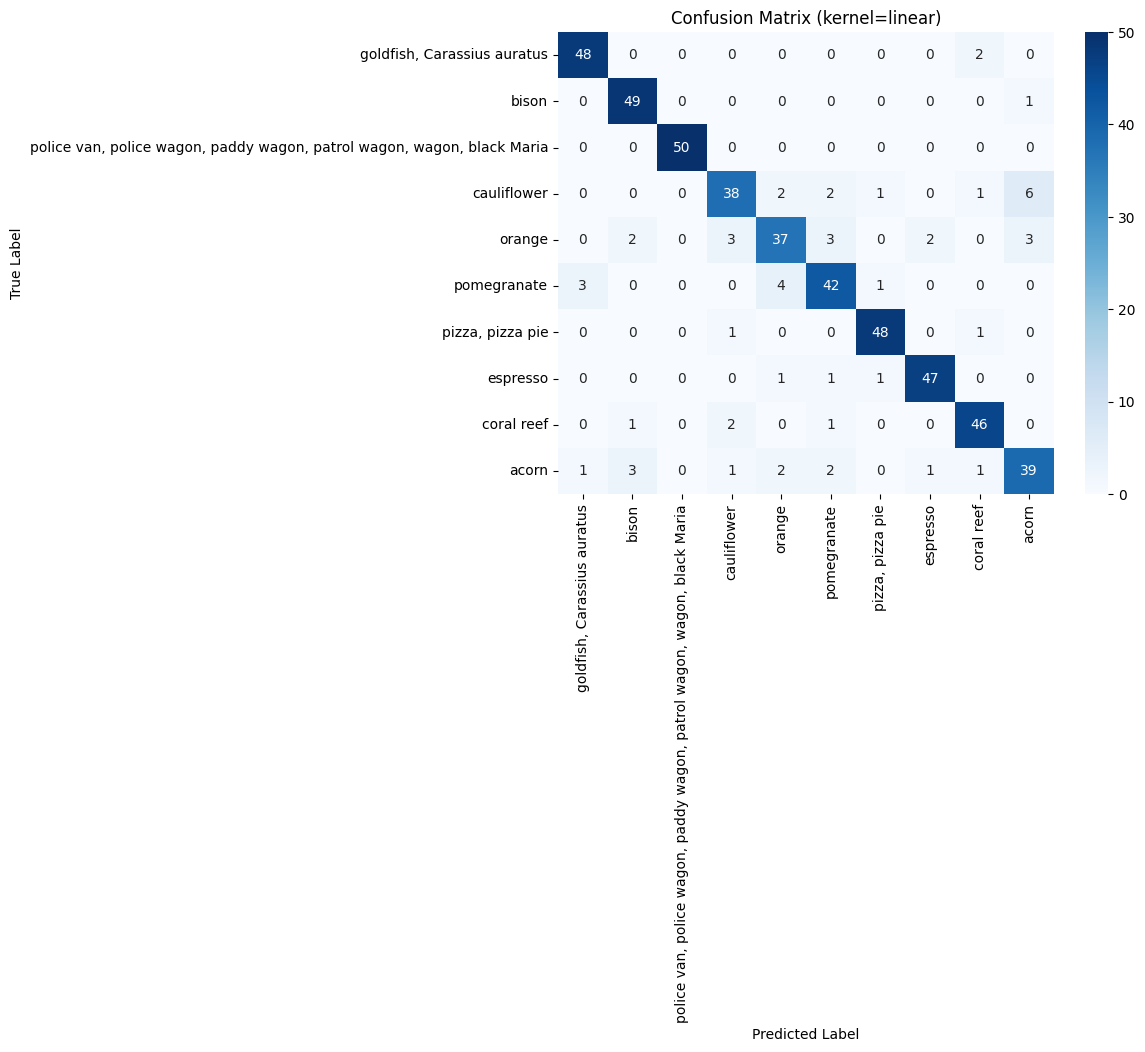


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Best C for kernel=rbf: 1.5
Validation Accuracy for kernel=rbf: 90.800%
              precision    recall  f1-score   support

   n01443537       0.98      0.94      0.96        50
   n02410509       0.91      0.98      0.94        50
   n03977966       1.00      1.00      1.00        50
   n07715103       0.93      0.80      0.86        50
   n07747607       0.88      0.86      0.87        50
   n07768694       0.87      0.92      0.89        50
   n07873807       0.94      0.96      0.95        50
   n07920052       0.96      0.96      0.96        50
   n09256479       0.90      0.90      0.90        50
   n12267677       0.73      0.76      0.75        50

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



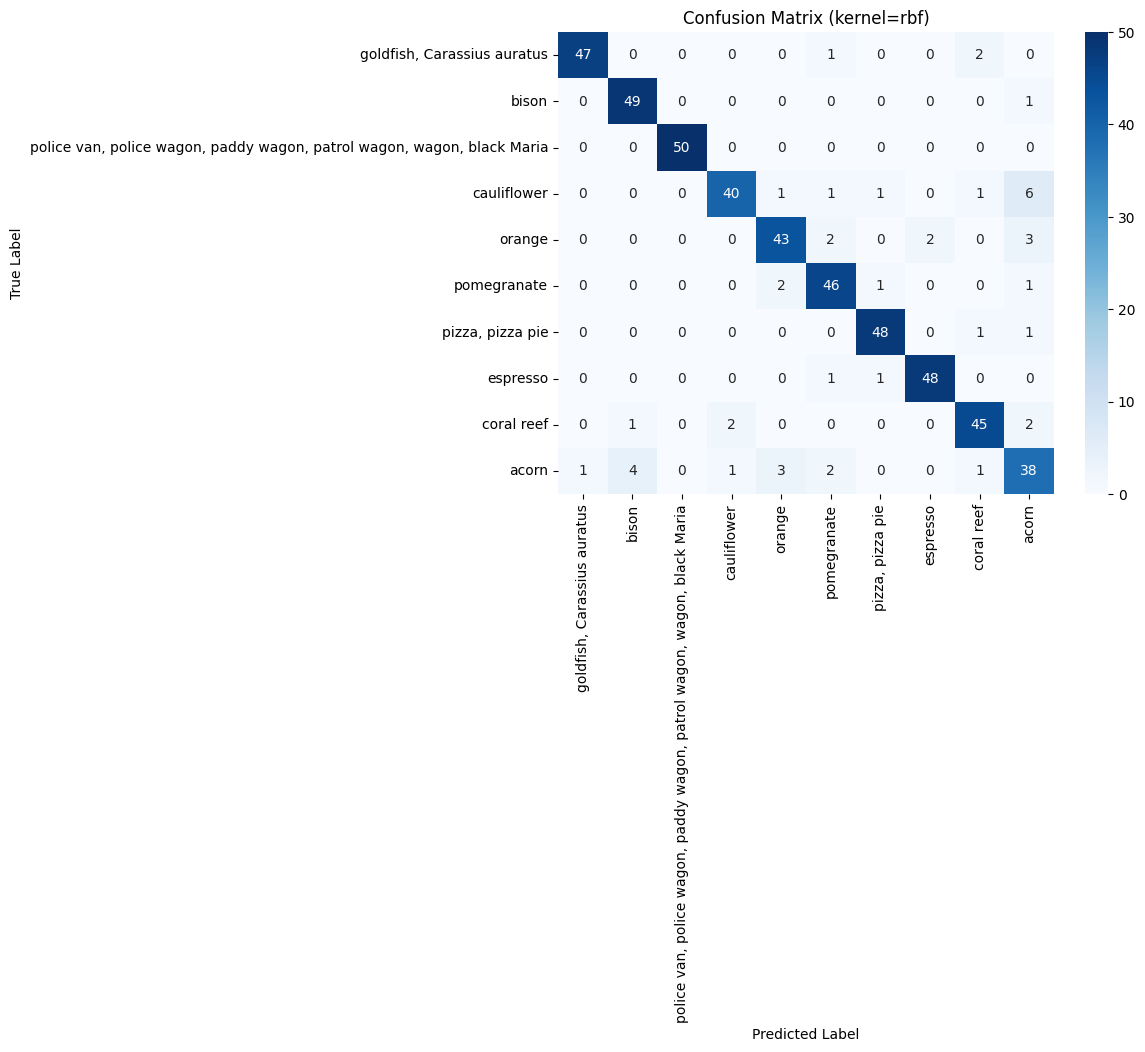


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Best C for kernel=poly: 1.5
Validation Accuracy for kernel=poly: 84.000%
              precision    recall  f1-score   support

   n01443537       0.96      0.86      0.91        50
   n02410509       0.94      0.94      0.94        50
   n03977966       1.00      0.98      0.99        50
   n07715103       0.70      0.80      0.75        50
   n07747607       0.91      0.64      0.75        50
   n07768694       0.85      0.78      0.81        50
   n07873807       0.91      0.80      0.85        50
   n07920052       0.96      0.88      0.92        50
   n09256479       0.92      0.88      0.90        50
   n12267677       0.53      0.84      0.65        50

    accuracy                           0.84       500
   macro avg       0.87      0.84      0.85       500
weighted avg       0.87      0.84      0.85       500



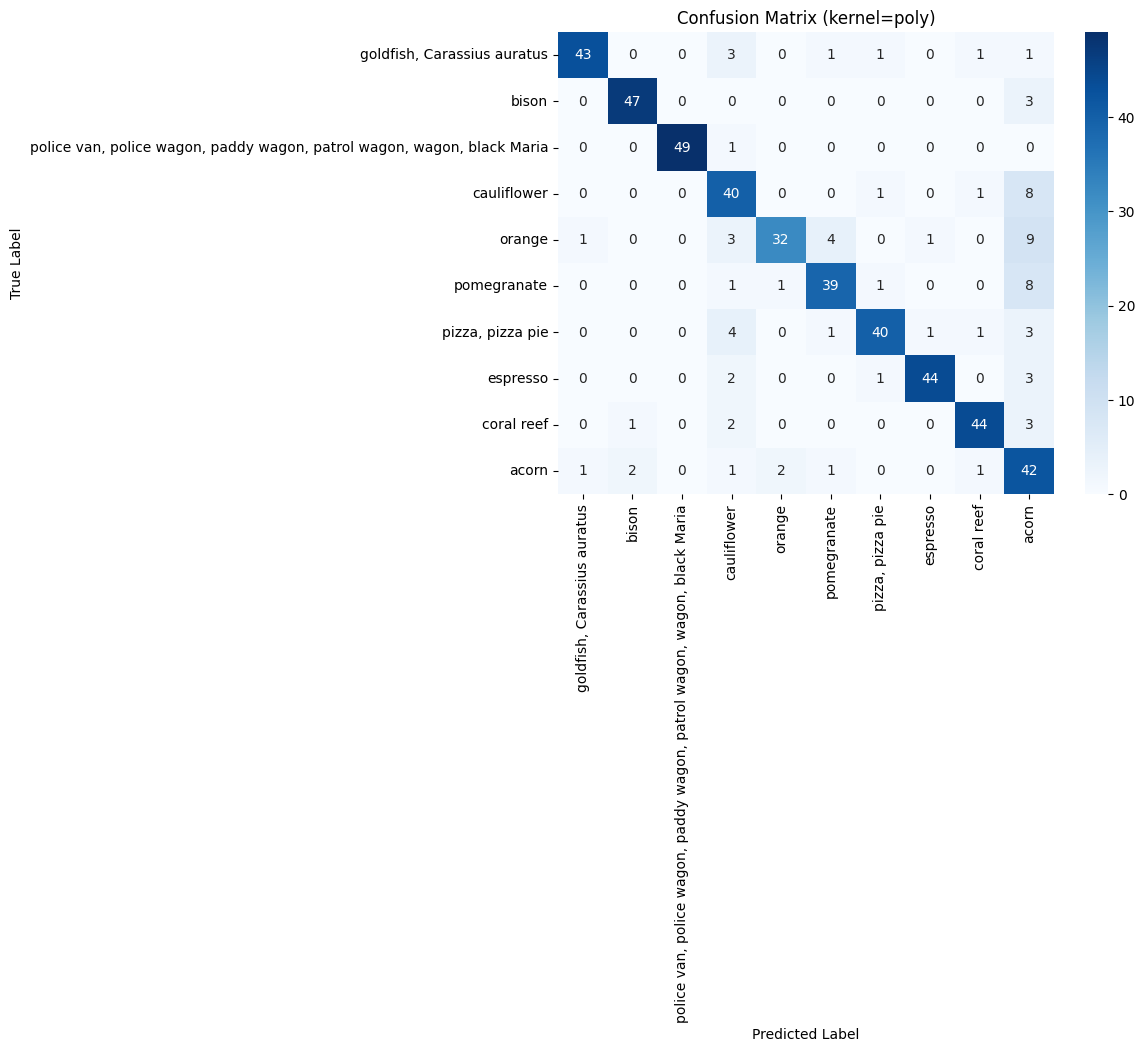


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Best C for kernel=sigmoid: 1.0
Validation Accuracy for kernel=sigmoid: 87.400%
              precision    recall  f1-score   support

   n01443537       0.96      0.94      0.95        50
   n02410509       0.89      0.98      0.93        50
   n03977966       1.00      1.00      1.00        50
   n07715103       0.90      0.70      0.79        50
   n07747607       0.83      0.76      0.79        50
   n07768694       0.81      0.84      0.82        50
   n07873807       0.84      0.92      0.88        50
   n07920052       0.96      0.94      0.95        50
   n09256479       0.87      0.92      0.89        50
   n12267677       0.71      0.74      0.73        50

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500



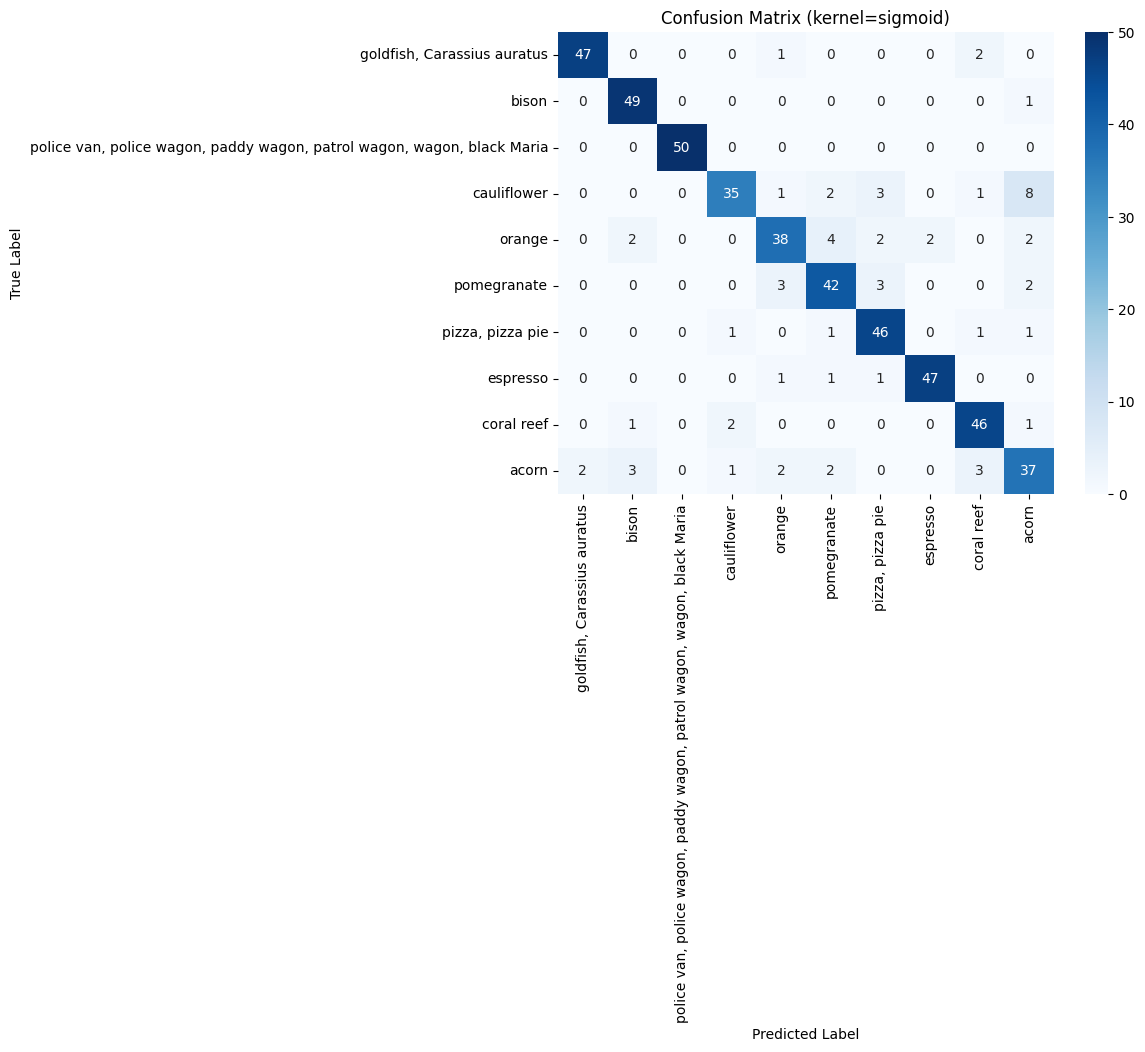


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-


In [ ]:
# Find the real names of the corresponded IDs
words_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjectML/data/words.txt', sep='\t', header=None, names=['id', 'label'])
id_to_name = dict(zip(words_df['id'], words_df['label']))
labels = sorted(np.unique(np.concatenate([y_train, y_test])))
labels = [id_to_name[label_id] for label_id in labels]

kerns = ['linear', 'rbf', 'poly', 'sigmoid']
C_range = [0.1, 0.5, 1.0, 1.5]

for k in kerns:

    param_grid = {'C': C_range}
    grid = GridSearchCV(SVC(kernel=k), param_grid, cv=3, scoring='accuracy')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print(f"Best C for kernel={k}: {grid.best_params_['C']}")

    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Validation Accuracy for kernel={k}: {accuracy * 100:.3f}%")

    print(classification_report(y_test, y_pred, zero_division=0))

    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix (kernel={k})")
    plt.show()

    print("\n -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")